In [1]:
#import libraries
import pandas as pd 
import numpy as np 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
#load dataset
df = pd.read_csv("USA_cars_datasets.csv")

In [3]:
# drop ID columns
drop_cols = ['Unnamed: 0', 'vin','lot','condition','country']
df=df.drop(drop_cols, axis=1)

In [4]:
#group similar colors together
df['color']=df['color'].replace('color:','no_color')
df['color']=df['color'].replace(['light blue','morningsky blue','dark blue','kona blue metallic','lightning blue',
                                'jazz blue pearlcoat',],'blue')
df['color']=df['color'].replace(['ruby red','toreador red','burgundy','royal crimson metallic tinted clearcoat',
                                'ruby red metallic tinted clearcoat','maroon','cayenne red'],'red')
df['color']=df['color'].replace(['phantom black','tuxedo black metallic', 'shadow black','super black',
                                'black clearcoat'] ,'black')
df['color']=df['color'].replace(['ingot silver','ingot silver metallic','billet silver metallic clearcoat'],'silver')
df['color']=df['color'].replace(['glacier white','pearl white','white platinum tri-coat metallic','oxford white',
                                 'bright white clearcoat','off-white'],'white')
df['color']=df['color'].replace(['competition orange'],'orange')
df['color']=df['color'].replace(['triple yellow tri-coat'],'yellow')
df['color']=df['color'].replace(['tan'],'brown')
df['color']=df['color'].replace(['magnetic metallic','guard'],'gray')

In [5]:
#drop where price equals zero
df = df.drop(df[df.price == 0].index)

In [6]:
#convert to dummy variables
dummy_brand = pd.get_dummies(df['brand'])
df=pd.concat([df,dummy_brand],axis=1)
df.drop(['brand'],axis=1,inplace=True)

model_dummy = pd.get_dummies(df['model'])
df=pd.concat([df,model_dummy],axis=1)
df.drop(['model'],axis=1,inplace=True)

title_dummy = pd.get_dummies(df['title_status'])
df=pd.concat([df,title_dummy],axis=1)
df.drop(['title_status'],axis=1,inplace=True)

color_dummy = pd.get_dummies(df['color'])
df=pd.concat([df,color_dummy],axis=1)
df.drop(['color'],axis=1,inplace=True)

state_dummy = pd.get_dummies(df['state'])
df=pd.concat([df,state_dummy],axis=1)
df.drop(['state'],axis=1,inplace=True)

In [7]:
#make sure datatypes are all numbers
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2498
Columns: 218 entries, price to wisconsin
dtypes: float64(1), int64(2), uint8(215)
memory usage: 592.4 KB


In [8]:
#train test split
features = df.drop('price',axis=1).values
target = df.price.values
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.20,shuffle=True)

### XGBRegressor

In [9]:
#using all the best params from gridsearch
xgb3 = XGBRegressor(objective='reg:squarederror',learning_rate=0.03, n_estimators=1000, max_depth=5,
        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
        reg_alpha=1, reg_lambda=0.45).fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred_xg3 = xgb3.predict(X_train)
y_pred_xg3 = xgb3.predict(X_test)

print ("Train r2 score:", r2_score(y_pred=y_train_pred_xg3,y_true=y_train))
print("Test r2 score:", r2_score(y_test, y_pred_xg3))
train_mse3 = mean_squared_error(y_train_pred_xg3, y_train)
test_mse3 = mean_squared_error(y_pred_xg3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print("Train RMSE: %.4f" % train_rmse3)
print("Test RMSE: %.4f" % test_rmse3)

Train r2 score: 0.8362508012780459
Test r2 score: 0.6724039216293608
Train RMSE: 4854.6439
Test RMSE: 6758.0046


In [10]:
#predict prices
prediction=xgb3.predict(X_test)
test=pd.DataFrame({"true price":(y_test),"predicted price":(prediction)})
print(test.sample(5))

     true price  predicted price
323       22800     26902.693359
312       24502     26104.767578
112       31800     22506.392578
346       38500     27686.853516
373       34400     28313.619141


In [13]:
import matplotlib.pyplot as plt

def rmse_graph(alg):
    """
    Plotting a graph to compare RMSE of training and test set
    :param: algorithm
    :return: RMSE graph
    """
    
    #eval metric
    eval_set = [(X_train, y_train), (X_test, y_test)]
    alg.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, verbose=False)
    
    # plot RMSE for training and test set
    results = alg.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train', color='blue')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test', color='red')
    ax.legend()
    plt.ylabel('Root Mean Square Error')
    plt.title('XGBoost RMSE')
    plt.show()

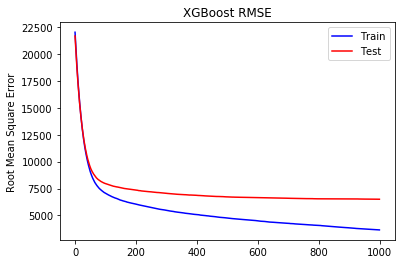

In [14]:
rmse_graph(xgb3)

In [15]:
df.shape

(2456, 218)